In [1]:
!pip install lingam
!pip install igraph
!pip install factor_analyzer
!pip install cdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 320 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=19721e874f4ce9bcf936f35d47b93682614d42ec499618235710a17c363f106f
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 921 kB 5.1 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl s

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
import itertools
import warnings
from sklearn import linear_model
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
import graphviz
import lingam
from lingam.utils import make_dot
import cdt
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
#@title
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
09/11/2016
Inputs:
X 		n by dim_x matrix
Y 		n by dim_y matrix
alph 		level of test
Outputs:
testStat	test statistics
thresh		test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
	size1 = pattern1.shape
	size2 = pattern2.shape

	G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
	H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)

	Q = np.tile(G, (1, size2[0]))
	R = np.tile(H.T, (size1[0], 1))

	H = Q + R - 2* np.dot(pattern1, pattern2.T)

	H = np.exp(-H/2/(deg**2))

	return H


def hsic_gam(X, Y, alph = 0.05):
	"""
	X, Y are numpy vectors with row - sample, col - dim
	alph is the significance level
	auto choose median to be the kernel width
	"""
	n = X.shape[0]

	# ----- width of X -----
	Xmed = X

	G = np.sum(Xmed*Xmed, 1).reshape(n,1)
	Q = np.tile(G, (1, n) )
	R = np.tile(G.T, (n, 1) )

	dists = Q + R - 2* np.dot(Xmed, Xmed.T)
	dists = dists - np.tril(dists)
	dists = dists.reshape(n**2, 1)

	width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
	# ----- -----

	# ----- width of X -----
	Ymed = Y

	G = np.sum(Ymed*Ymed, 1).reshape(n,1)
	Q = np.tile(G, (1, n) )
	R = np.tile(G.T, (n, 1) )

	dists = Q + R - 2* np.dot(Ymed, Ymed.T)
	dists = dists - np.tril(dists)
	dists = dists.reshape(n**2, 1)

	width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
	# ----- -----

	bone = np.ones((n, 1), dtype = float)
	H = np.identity(n) - np.ones((n,n), dtype = float) / n

	K = rbf_dot(X, X, width_x)
	L = rbf_dot(Y, Y, width_y)

	Kc = np.dot(np.dot(H, K), H)
	Lc = np.dot(np.dot(H, L), H)

	testStat = np.sum(Kc.T * Lc) / n

	varHSIC = (Kc * Lc / 6)**2

	varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)

	varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)

	K = K - np.diag(np.diag(K))
	L = L - np.diag(np.diag(L))

	muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
	muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)

	mHSIC = (1 + muX * muY - muX - muY) / n

	al = mHSIC**2 / varHSIC
	bet = varHSIC*n / mHSIC

	thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]

	return (testStat, thresh)
 

def hsic_gam_wrapper(y1, y2):
    return hsic_gam(y1, y2)[0]

In [4]:
#@title
"""ReBias
Copyright (c) 2020-present NAVER Corp.
MIT license
Python Implementation of the finite sample estimator of Hilbert-Schmidt Independence Criterion (HSIC)
We provide both biased estimator and unbiased estimators (unbiased estimator is used in the paper)
"""
import torch
import torch.nn as nn


def to_numpy(x):
    """convert Pytorch tensor to numpy array
    """
    return x.clone().detach().cpu().numpy()


class HSIC(nn.Module):
    """Base class for the finite sample estimator of Hilbert-Schmidt Independence Criterion (HSIC)
    ..math:: HSIC (X, Y) := || C_{x, y} ||^2_{HS}, where HSIC (X, Y) = 0 iif X and Y are independent.
    Empirically, we use the finite sample estimator of HSIC (with m observations) by,
    (1) biased estimator (HSIC_0)
        Gretton, Arthur, et al. "Measuring statistical dependence with Hilbert-Schmidt norms." 2005.
        :math: (m - 1)^2 tr KHLH.
        where K_{ij} = kernel_x (x_i, x_j), L_{ij} = kernel_y (y_i, y_j), H = 1 - m^{-1} 1 1 (Hence, K, L, H are m by m matrices).
    (2) unbiased estimator (HSIC_1)
        Song, Le, et al. "Feature selection via dependence maximization." 2012.
        :math: \frac{1}{m (m - 3)} \bigg[ tr (\tilde K \tilde L) + \frac{1^\top \tilde K 1 1^\top \tilde L 1}{(m-1)(m-2)} - \frac{2}{m-2} 1^\top \tilde K \tilde L 1 \bigg].
        where \tilde K and \tilde L are related to K and L by the diagonal entries of \tilde K_{ij} and \tilde L_{ij} are set to zero.
    Parameters
    ----------
    sigma_x : float
        the kernel size of the kernel function for X.
    sigma_y : float
        the kernel size of the kernel function for Y.
    algorithm: str ('unbiased' / 'biased')
        the algorithm for the finite sample estimator. 'unbiased' is used for our paper.
    reduction: not used (for compatibility with other losses).
    """
    def __init__(self, sigma_x, sigma_y=None, algorithm='unbiased',
                 reduction=None):
        super(HSIC, self).__init__()

        if sigma_y is None:
            sigma_y = sigma_x

        self.sigma_x = sigma_x
        self.sigma_y = sigma_y

        if algorithm == 'biased':
            self.estimator = self.biased_estimator
        elif algorithm == 'unbiased':
            self.estimator = self.unbiased_estimator
        else:
            raise ValueError('invalid estimator: {}'.format(algorithm))

    def _kernel_x(self, X):
        raise NotImplementedError

    def _kernel_y(self, Y):
        raise NotImplementedError

    def biased_estimator(self, input1, input2):
        """Biased estimator of Hilbert-Schmidt Independence Criterion
        Gretton, Arthur, et al. "Measuring statistical dependence with Hilbert-Schmidt norms." 2005.
        """
        K = self._kernel_x(input1)
        L = self._kernel_y(input2)

        KH = K - K.mean(0, keepdim=True)
        LH = L - L.mean(0, keepdim=True)

        N = len(input1)

        return torch.trace(KH @ LH / (N - 1) ** 2)

    def unbiased_estimator(self, input1, input2):
        """Unbiased estimator of Hilbert-Schmidt Independence Criterion
        Song, Le, et al. "Feature selection via dependence maximization." 2012.
        """
        kernel_XX = self._kernel_x(input1)
        kernel_YY = self._kernel_y(input2)

        tK = kernel_XX - torch.diag(kernel_XX)
        tL = kernel_YY - torch.diag(kernel_YY)

        N = len(input1)

        hsic = (
            torch.trace(tK @ tL)
            + (torch.sum(tK) * torch.sum(tL) / (N - 1) / (N - 2))
            - (2 * torch.sum(tK, 0).dot(torch.sum(tL, 0)) / (N - 2))
        )

        return hsic / (N * (N - 3))

    def forward(self, input1, input2, **kwargs):
        return self.estimator(input1, input2)


class RbfHSIC(HSIC):
    """Radial Basis Function (RBF) kernel HSIC implementation.
    """
    def _kernel(self, X, sigma):
        X = X.view(len(X), -1)
        XX = X @ X.t()
        X_sqnorms = torch.diag(XX)
        X_L2 = -2 * XX + X_sqnorms.unsqueeze(1) + X_sqnorms.unsqueeze(0)
        gamma = 1 / (2 * sigma ** 2)

        kernel_XX = torch.exp(-gamma * X_L2)
        return kernel_XX

    def _kernel_x(self, X):
        return self._kernel(X, self.sigma_x)

    def _kernel_y(self, Y):
        return self._kernel(Y, self.sigma_y)


class MinusRbfHSIC(RbfHSIC):
    """``Minus'' RbfHSIC for the ``max'' optimization.
    """
    def forward(self, input1, input2, **kwargs):
        return -self.estimator(input1, input2)

In [5]:
#@title
# Mutual information

def K_i(y, sigma):
    y = y.reshape((y.size, 1))
    return np.exp( - 1/(2 *sigma**2) * (y - y.T)**2)


def MI_kernel(y1, y2, sigma=1, kappa=2e-2):
    K1 = K_i(y1, sigma)
    K2 = K_i(y2, sigma)
    n = K1.shape[0]

    block_0 = np.zeros(K1.shape)
    block_1 = np.linalg.matrix_power(K1 + np.eye(n) * (n * kappa) / 2, 2)
    block_2 = K1 @ K2
    block_3 = K2 @ K1
    block_4 = np.linalg.matrix_power(K2 + np.eye(n) * (n * kappa) / 2, 2)
    

    K_k = np.block([[block_1, block_2], [block_3, block_4]])
    D_k = np.block([[block_1, block_0], [block_0, block_4]])

    det_1 = np.linalg.slogdet(block_1)
    #det_2 = np.linalg.det(block_2)
    #det_3 = np.linalg.det(block_3)
    det_4 = np.linalg.slogdet(block_4)
    
    logdet_D_k = det_1[1] + det_4[1]

    logdet_K_k = np.linalg.slogdet(block_1 @ block_4 - block_2 @ block_3)

    sign_D_k = det_1[0] * det_4[0]
    sign_K_k = logdet_K_k[0]
 

    return - 1/2 * sign_K_k * sign_D_k * (logdet_K_k[1] - logdet_D_k)

    
def construct_mutual_information_matrix(X):
    measures = [hsic_gam_wrapper]#, MI_kernel]#, pearsonr_wrapper]
    measures = [MI_kernel]

    MI = np.zeros((X.shape[0], X.shape[0], len(measures)))
    R = np.zeros((X.shape[0], X.shape[0], X.shape[1]))
    X_stacked = np.tile(X, (X.shape[0], 1, 1))
    covX = np.cov(X)

    for k in range(X.shape[0]):
        #print(X_stacked[:, k, :].shape)
        residuals = (X - (covX[k, :].reshape((covX.shape[0], 1)) / covX[k, k]) * X_stacked[:, k, :])
        #print(residuals)
        R[k, :, :] = residuals

        
        mis = np.zeros((residuals.shape[0], len(measures)))

        for i in range(residuals.shape[0]):
            if i == k:
                MI[k, i, :] = np.nan
                continue
            y1 = X[k, :].reshape((X[k, :].size, 1))
            #print(y1.shape)
            y2 = residuals[i, :].reshape((residuals[i, :].size, 1))

            for j in range(len(measures)):
                measure = measures[j](y1, y2)
                #print(measure)
                MI[k, i, j] = measures[j](y1, y2)

    return MI.squeeze(), R


In [6]:
# Import demographics
demographics_url = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/demographics.csv'
df_demo = pd.read_csv(demographics_url, sep=',').rename({'Unnamed: 0': 'part_id'}, axis=1)

# Import sanity checks
sanity_checks_url = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/sanity_checks.csv'
sanity_checks_in = pd.read_csv(sanity_checks_url, sep=',').drop('Unnamed: 0', axis=1)

# Task data
df_task = f'https://raw.githubusercontent.com/vbtCogSci/features_of_agency/master/data/datasets/properties_1/datasets_csv/task_data.csv'
df_task = pd.read_csv(df_task).drop('Unnamed: 0', axis=1)

In [7]:
properties = df_task.columns[4:-4].to_list()
properties_agency = df_task.columns[4:-3].to_list()
properties_full = df_task.columns[4:].to_list()

X = df_task[properties_agency].to_numpy().T 
U_label = properties_agency

print(properties)
print(properties_agency)
print(properties_full)
df_task.columns

['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring']
['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring', 'agency']
['movement', 'energy', 'replication', 'complexity', 'learning', 'reaction', 'mistakes', 'communication', 'variety', 'monitoring', 'agency', 'goal_setting', 'goal_directedness', 'freewill']


Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')

In [8]:
df_task.groupby('word').mean().loc[['car', 'robot_vacuum_cleaner', 'thermostat', 'wristwatch'] + ['hammer', 'rock']]
#df_task.groupby('word').mean().loc[]

,part_id,reaction_time,slider_order,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring,agency,goal_setting,goal_directedness,freewill
word,,,,,,,,,,,,,,,,,
car,6503117.5,42711.590,2.5,35.50,90.55,3.60,85.40,7.45,32.55,45.95,15.95,29.60,14.95,12.15,5.65,21.50,1.25
robot_vacuum_cleaner,6503117.5,53180.590,2.5,65.30,82.40,1.65,73.05,32.45,46.40,48.15,24.85,28.80,30.25,19.10,12.25,33.70,3.00
thermostat,6503117.5,49085.760,2.5,8.95,71.30,2.90,45.90,4.15,39.75,30.15,13.20,9.70,13.00,12.15,8.90,21.95,1.15
wristwatch,6503117.5,95319.745,2.5,16.15,72.10,1.05,65.35,6.50,19.35,35.90,18.80,23.80,13.90,15.50,6.90,10.15,3.50
hammer,6503117.5,38366.295,2.5,0.95,37.70,1.10,9.40,1.90,11.55,12.40,1.25,26.55,1.35,10.70,1.60,17.65,1.35
rock,6503117.5,72264.715,2.5,5.30,12.45,5.45,20.15,1.00,35.00,1.00,1.95,14.30,0.95,2.10,0.80,1.05,15.05


In [9]:
df_task[properties_full]

,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring,agency,goal_setting,goal_directedness,freewill
0,63.0,88.0,15.0,88.0,69.0,64.0,88.0,78.0,79.0,46.0,13.0,46.0,48.0,56.0
1,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,85.0,11.0,72.0,5.0,65.0,71.0,68.0,79.0,89.0,1.0,81.0,58.0,4.0
3,0.0,93.0,1.0,80.0,1.0,62.0,39.0,13.0,83.0,4.0,1.0,3.0,3.0,2.0
4,54.0,89.0,2.0,87.0,0.0,2.0,44.0,1.0,74.0,3.0,3.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,100.0,0.0,93.0,53.0,50.0,100.0,0.0,100.0,88.0,0.0,67.0,100.0,0.0
396,0.0,100.0,0.0,88.0,53.0,63.0,100.0,50.0,100.0,100.0,0.0,54.0,100.0,0.0
397,0.0,76.0,0.0,0.0,0.0,0.0,100.0,0.0,82.0,0.0,0.0,0.0,100.0,0.0
398,0.0,79.0,0.0,73.0,23.0,100.0,92.0,0.0,23.0,76.0,0.0,22.0,100.0,0.0


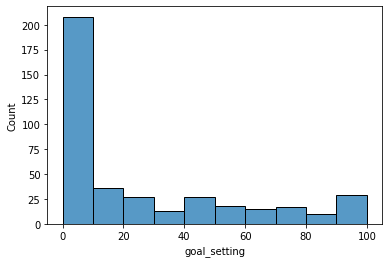

In [10]:
sns.histplot(df_task.goal_setting)

## Causal discovery using DirectLINGAM (Shimizu et al., 2011)

In [11]:

def causal_order(X_init, U_label):
    X = X_init
    U = [i for i in range(len(U_label))]
    K = []
    U_not_K = [i for i in range(len(U)) if i not in K]
    U_left_loc = [i for i in range(len(U)) if i not in K]
    m = 0

    idx = 0
    while len(K) < len(U) - 1:
        print(idx)
        print(K)
        print(U_not_K)
        print(U_left_loc)

        # Compute independence
        MI, R = construct_mutual_information_matrix(X)
        # Pick m = argmin x (indep)
        m_0 = np.argmin(np.nansum(MI, axis=1))

        m = U_not_K[m_0]

        K.append(m)
        U_not_K = [i for i in range(len(U)) if i not in K]
        U_left_loc = [i for i in range(MI.shape[0]) if i != m_0]

        # Set x = r_m, X = R_m
        X = R[m_0, U_left_loc, :] 

        idx += 1

    K.append(U_not_K[0])

    return K


In [14]:
X = df_task[properties_full].to_numpy().T 
U_label = properties_full

K = causal_order(X, U_label)

0
[]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
1
[6]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]
2
[6, 2]
[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
3
[6, 2, 4]
[0, 1, 3, 5, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
4
[6, 2, 4, 5]
[0, 1, 3, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
5
[6, 2, 4, 5, 0]
[1, 3, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8]
6
[6, 2, 4, 5, 0, 7]
[1, 3, 8, 9, 10, 11, 12]
[0, 1, 3, 4, 5, 6, 7]
7
[6, 2, 4, 5, 0, 7, 8]
[1, 3, 9, 10, 11, 12]
[0, 1, 3, 4, 5, 6]
8
[6, 2, 4, 5, 0, 7, 8, 9]
[1, 3, 10, 11, 12]
[0, 1, 3, 4, 5]
9
[6, 2, 4, 5, 0, 7, 8, 9, 10]
[1, 3, 11, 12]
[0, 1, 3, 4]
10
[6, 2, 4, 5, 0, 7, 8, 9, 10, 3]
[1, 11, 12]
[0, 2, 3]
11
[6, 2, 4, 5, 0, 7, 8, 9, 10, 3, 1]
[11, 12]
[1, 2]


In [15]:
np.array(U_label)[K]

array(['mistakes', 'replication', 'learning', 'reaction', 'movement',
       'communication', 'variety', 'monitoring', 'agency', 'complexity',
       'energy', 'goal_directedness', 'goal_setting'], dtype='<U17')

In [17]:
K_hsic = np.array(['energy', 'complexity', 'replication', 'movement', 'agency',
       'goal_setting', 'goal_directedness', 'learning', 'reaction',
       'communication', 'variety', 'monitoring'], dtype='<U17')
print(K_hsic)

['energy' 'complexity' 'replication' 'movement' 'agency' 'goal_setting'
 'goal_directedness' 'learning' 'reaction' 'communication' 'variety'
 'monitoring']


In [21]:
X.shape

(13, 400)

In [66]:

# Construct B
print(K)
B = np.zeros((X.shape[0], X.shape[0]))
P = np.zeros((X.shape[0], X.shape[0]))
covX = np.cov(X)

for i, p in enumerate(K):
    #print(i, p)
    for j, c in enumerate(K[:i]):
        #print(j, c)
        coef = covX[i, j] / (covX[i, i])
        r, p = stats.pearsonr(X[i, :], X[j, :])
        #print(r)
        P[j, i] = p
        if p < 5e-2:
            B[j, i] = coef
        

print(np.round(B, 2))
print(np.round(P, 2))
        

[6, 2, 4, 5, 0, 7, 8, 9, 10, 3, 1, 12, 11]
[[0.   0.53 0.55 0.48 0.59 0.74 0.5  0.49 0.36 0.52 0.5  0.63 0.49]
 [0.   0.   0.1  0.49 0.31 0.26 0.37 0.37 0.35 0.32 0.32 0.26 0.27]
 [0.   0.   0.   0.18 0.45 0.64 0.22 0.3  0.24 0.39 0.4  0.57 0.28]
 [0.   0.   0.   0.   0.4  0.35 0.47 0.4  0.49 0.47 0.37 0.36 0.3 ]
 [0.   0.   0.   0.   0.   0.63 0.64 0.72 0.63 0.73 0.71 0.75 0.55]
 [0.   0.   0.   0.   0.   0.   0.42 0.52 0.41 0.56 0.55 0.64 0.47]
 [0.   0.   0.   0.   0.   0.   0.   0.59 0.7  0.68 0.58 0.68 0.6 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.66 0.69 0.73 0.69 0.52]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.64 0.48 0.61 0.52]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.55 0.73 0.57]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.58 0.4 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.63]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.

In [14]:
# CAM and CDT

model = cdt.causality.graph.CAM()

ImportError: ignored

Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')
[0, 2, 5, 8, 9, 4, 7, 10, 1, 3, 6]
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.04 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.  ]
 [0.   0.   0.05 0.   0.   0.02 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


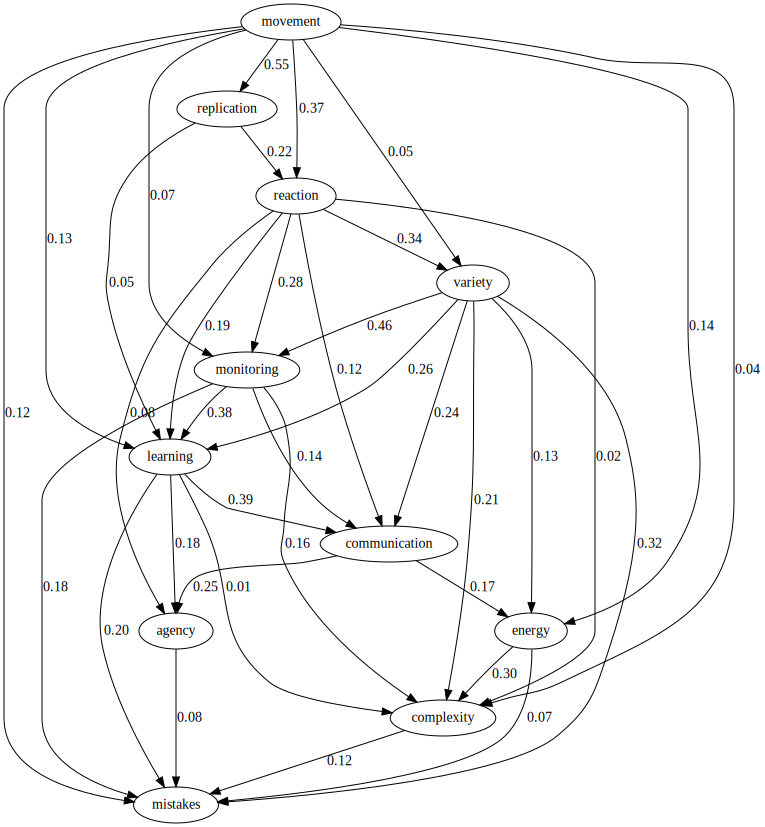

In [12]:
words = ['human', 'hammer', 'rock', 'tree']
#df = df_task[df_task.word.isin(words)]
df = df_task
print(df.columns)
X = df[properties_agency].to_numpy().T 
U_label = properties_agency

model = lingam.ICALiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values(X.T)
print(np.round(p_values, 2))

cleaner_matrix = np.zeros(model.adjacency_matrix_.shape)
mask = model.adjacency_matrix_ > 1e-2
cleaner_matrix[mask] = model.adjacency_matrix_[mask]
make_dot(cleaner_matrix, labels=U_label)

Index(['part_id', 'word', 'reaction_time', 'slider_order', 'movement',
       'energy', 'replication', 'complexity', 'learning', 'reaction',
       'mistakes', 'communication', 'variety', 'monitoring', 'agency',
       'goal_setting', 'goal_directedness', 'freewill'],
      dtype='object')
[2, 1, 10, 0, 3, 9, 7, 4, 5, 8, 6]
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.02 0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.   0.43 0.   0.01 0.45 0.01 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.  ]
 [0.   0.   0.43 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.45 0.02 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.11 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


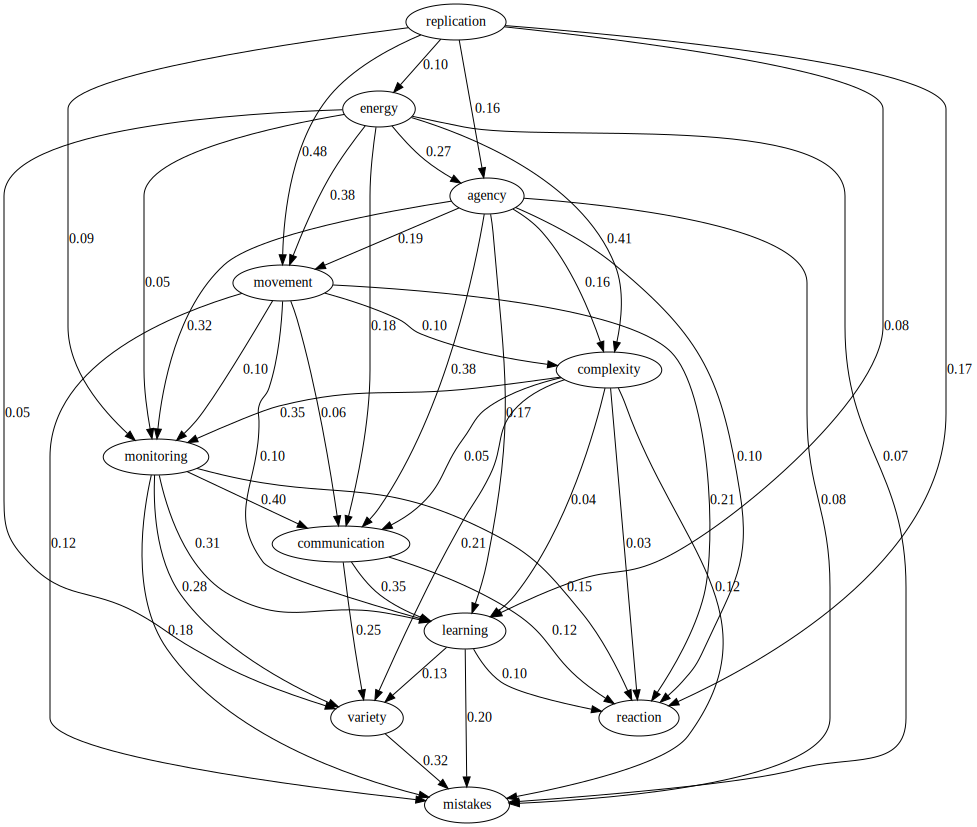

In [122]:
words = ['human', 'hammer', 'rock', 'tree']
#df = df_task[df_task.word.isin(words)]
df = df_task
print(df.columns)
X = df[properties_agency].to_numpy().T 
U_label = properties_agency

model = lingam.DirectLiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values(X.T)
print(np.round(p_values, 2))

cleaner_matrix = np.zeros(model.adjacency_matrix_.shape)
mask = model.adjacency_matrix_ > 1e-2
cleaner_matrix[mask] = model.adjacency_matrix_[mask]
make_dot(cleaner_matrix, labels=U_label)

In [127]:
df = df_task
#print(df.columns)
X = df[properties_agency].to_numpy().T 
U_label = properties_agency

model = lingam.VARMALiNGAM()
model.fit(X.T)

print(model.causal_order_)

p_values = model.get_error_independence_p_values()
print(np.round(p_values, 2))

adj = model.adjacency_matrices_[0][0, :, :]
cleaner_matrix = np.zeros(adj.shape)
mask = adj > 1.5e-1
cleaner_matrix[mask] = adj[mask]
make_dot(cleaner_matrix, labels=U_label)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[1, 2, 3, 10, 0, 9, 7, 8, 4, 5, 6]
[[0.   0.   0.   0.02 0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.07 0.   0.   0.24 0.17 0.01 0.4  0.  ]
 [0.02 0.   0.07 0.   0.   0.   0.07 0.11 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.12]
 [0.   0.   0.24 0.07 0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.17 0.11 0.   0.   0.   0.   0.   0.   0.54]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.4  0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.12 0.   0.54 0.   0.   0.  ]]


TypeError: ignored

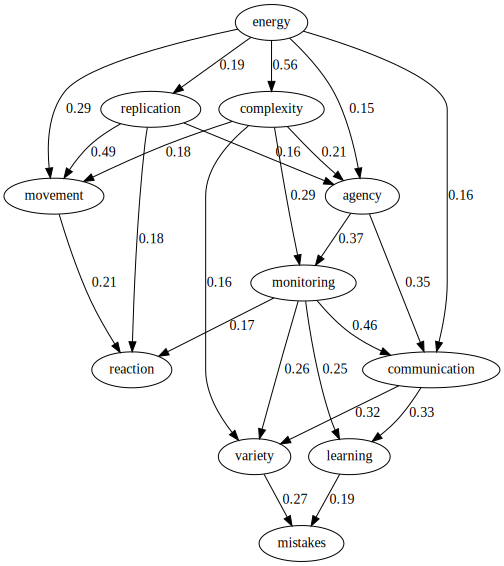

In [131]:
adj = model.adjacency_matrices_[0][0, :, :]
cleaner_matrix = np.zeros(adj.shape)
mask = adj > 1.5e-1
cleaner_matrix[mask] = adj[mask]
make_dot(cleaner_matrix, labels=U_label)

In [8]:

df_task['mean_score'] = df_task[properties].mean(axis=1)
df_means = df_task[['word'] + properties].groupby('word').mean()#.sort_values('agency')
df_means

,movement,energy,replication,complexity,learning,reaction,mistakes,communication,variety,monitoring
word,,,,,,,,,,
artificial_intelligence,31.05,73.75,28.00,76.10,69.45,60.90,77.15,66.55,75.40,64.45
autonomous_car,70.90,90.35,1.70,91.10,42.30,55.80,71.70,37.60,54.05,40.95
biological_virus,69.30,67.10,89.45,51.75,34.00,68.80,27.75,12.05,34.60,23.55
car,35.50,90.55,3.60,85.40,7.45,32.55,45.95,15.95,29.60,14.95
chicken,97.10,87.95,90.75,78.95,54.75,77.55,65.85,54.20,58.30,40.40
chimpanzee,95.15,92.20,84.40,88.75,81.05,88.30,87.50,79.90,81.00,62.95
computer,1.20,94.10,4.35,90.00,48.30,33.35,60.30,43.55,84.45,45.55
computer_virus,28.75,56.80,76.65,53.00,29.15,43.25,31.80,24.30,35.40,27.35
dolphin,96.45,94.40,84.80,86.45,81.55,87.00,80.45,82.35,74.05,64.95


In [9]:
X = df_means.to_numpy()
labels = df_means.index.to_list()


In [10]:
n_components = np.arange(3, 20)
covariances = ['full', 'diag']

num_samples = 15

model_selection = pd.DataFrame(columns=['n_comp', 'cov', 'bic'])
for c in n_components:
    for cov in covariances:
        for i in range(num_samples):
            gm = GaussianMixture(n_components=c, covariance_type=cov).fit(X)
            model_selection.loc[model_selection.index.size] = [c, cov, gm.bic(X)]

KeyboardInterrupt: ignored

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.barplot(x='n_comp', y='bic', hue='cov', data=model_selection, ax=ax)

plt.show()

In [ ]:
num_components = 20
cov = 'full'

gm = GaussianMixture(n_components=num_components, covariance_type=cov).fit(X)

print(f'BIC: {gm.bic(X)}')
print(np.round(gm.weights_, 4))
print()
print(np.round(gm.means_, 4))
print()

for i in range(gm.covariances_.shape[0]):
    print(np.round(np.diag(gm.covariances_[i, :, :])**(1/2), 4))

plt.hist(gm.predict_proba(X).max(axis=1))
plt.show()

In [ ]:
a = gm.predict(X)

df_means['assignment'] = a

df_means.sort_values('assignment')

In [ ]:
sns.histplot(df_task[df_task.word == 'computer_virus'].agency)

In [ ]:
sns.histplot(df_task.agency)

In [ ]:
pids = df_demo.part_id.to_list()

for i, pid in enumerate(pids):
    df_pid = df_task.loc[df_task.part_id == pid].sort_values('mean_score')
    lower_scores = df_pid.loc[df_pid.index[:2]].word.to_list()
    #if not ('rock' in lower_scores and 'hammer' in lower_scores):
    if not ('rock' in lower_scores):
        remove = np.ones(df_pid.shape[0])
    else:
        remove = np.zeros(df_pid.shape[0])

    df_task.loc[df_pid.index, 'exclude'] = remove

In [ ]:
df_task[df_task.exclude == 0]